# Gaussian process regression

In [1]:
### Importing Libraries and csv file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as WK, Matern, RBF, DotProduct as Lin, RationalQuadratic as RQ, ExpSineSquared as Exp
np.random.seed(1)

#working_directory = os.getcwd()

#path = working_directory + '/house_dataset.csv'
dataset = pd.read_csv("/Users/ridsmbp/Library/CloudStorage/OneDrive-Personal/Riddhi Machine Learning/Datasets/Datasets/GPR Housing Dataset/house_dataset.csv")
dataset.head()


id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7      1180.0              0   
1      7242     2.0           0     0  ...      7      2170.0            400   
2     10000     1.0           0     0  ...      6       770.0              0   
3      5000     1.0           0     0  ...      7      1050.0            910   
4      8080     1.0           0     0  ...      8      1680.0              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [2]:
# Getting the number of missing values in each column
num_missing = dataset.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]
# Getting the percentages of missing values
percent_missing = num_missing * 100 / dataset.shape[0]
# Concatenating the number and perecentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

Missing Values  Percentage
sqft_above               2    0.009254

In [3]:
# identify the columns that have missing values
na_cols = dataset.columns[dataset.isna().any()]

# filter out the rows that have missing values in the identified columns
dataset = dataset.dropna(subset=na_cols)

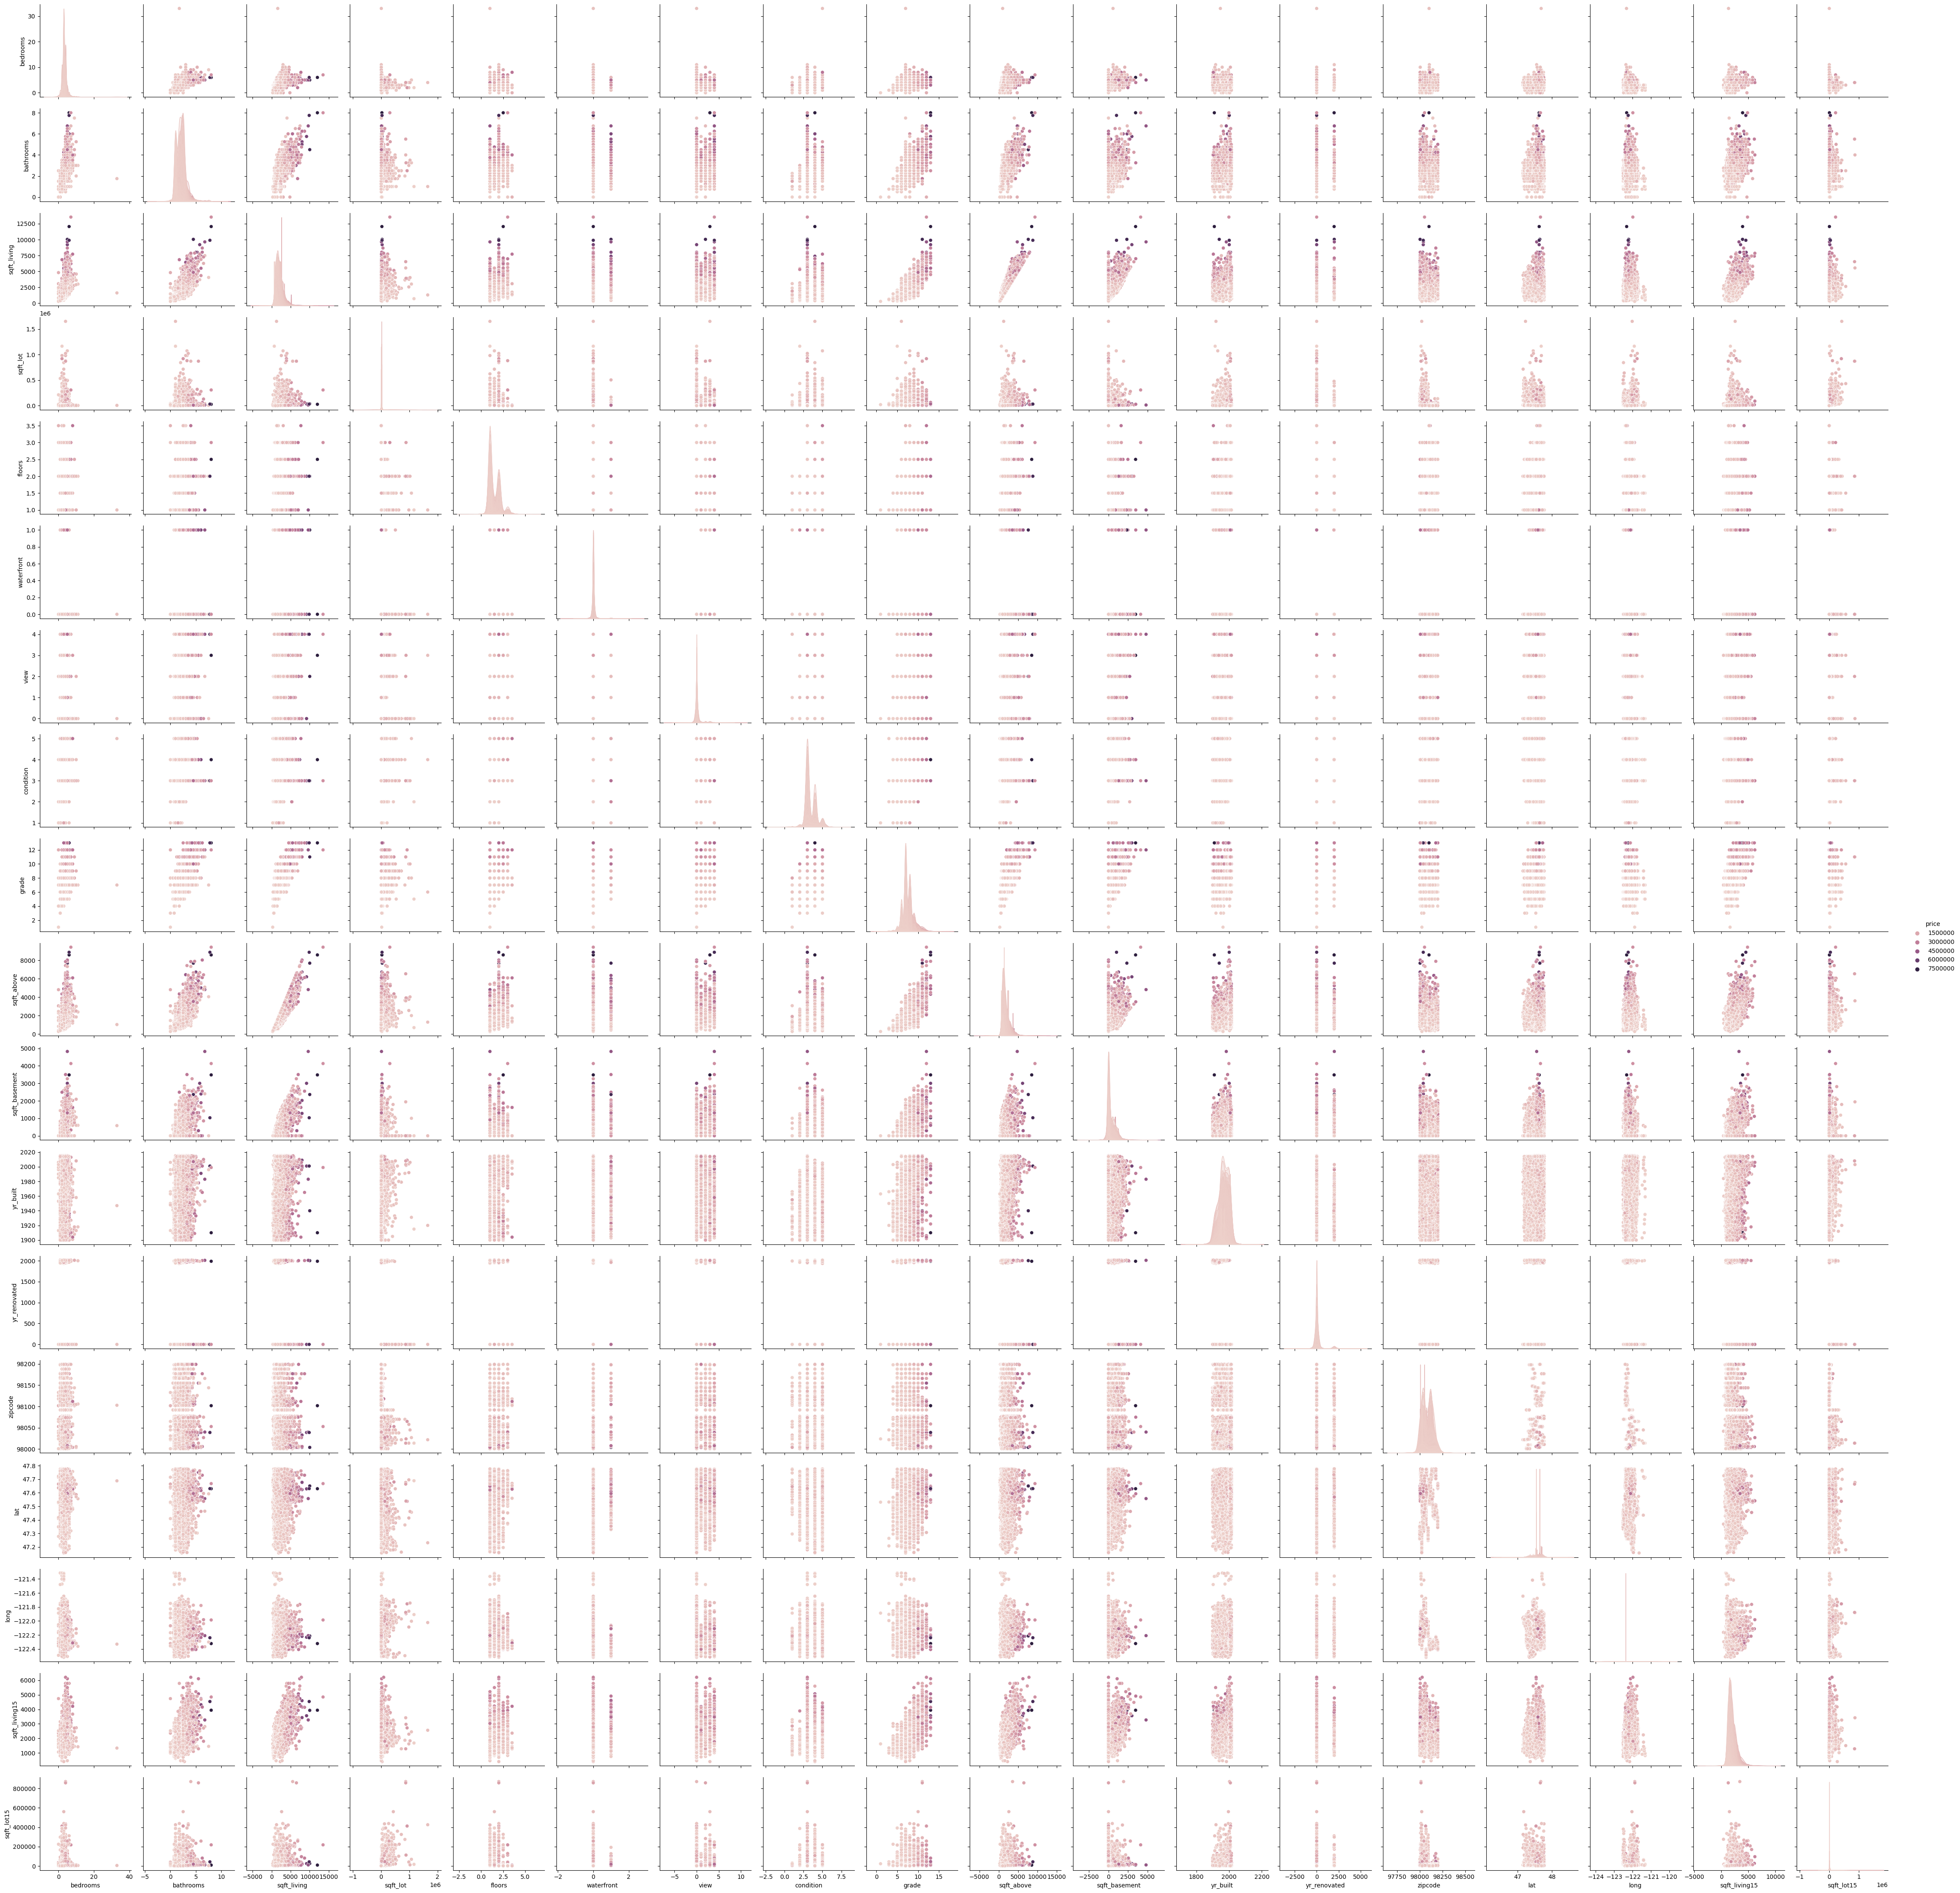

In [4]:
sns.pairplot (dataset, vars = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15"], hue="price")

In [5]:
X = dataset.drop(['price', 'id','date'], axis=1)
y = dataset['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# print the shapes of X and y
print(f"X_train shape: {X_train.shape}")
print(f"X_test: {X_test.shape}")


X_train shape: (17288, 18)
X_test: (4323, 18)


In [6]:
from xgboost import XGBRegressor

XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
             objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, 
             gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
             colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
             scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
             missing=None, importance_type='gain')


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=1, missing=None,
             monotone_constraints=None, n_estimators=100, n_jobs=1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

clf = RandomizedSearchCV(XGBRegressor(random_state=3), 
                         parameter_space, cv=3, n_jobs=4,
                         scoring="neg_mean_absolute_error", 
                         random_state=3, n_iter=10)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'subsample': 0.3, 'reg_lambda': 3, 'reg_alpha': 33, 'n_estimators': 2500, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 25, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'booster': 'gbtree'}


In [8]:
xgb_model = XGBRegressor(**clf.best_params_)

In [9]:
xgb_model.fit(X_train, y_train);

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
y_test_pred_xgb = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_test_pred_xgb)


# Compute R^2 for Ridge model
r2_xgb = r2_score(y_test, y_test_pred_xgb)

print("XGBoost MAE =", xgb_mae)
print("XGBoost R^2 =", r2_xgb)

XGBoost MAE = 68787.68017182802
XGBoost R^2 = 0.8924129255614445


In [14]:
# Add columns to the dataset
X_test['xgb_pred'] = y_test_pred_xgb

X_test['XGBoost R^2'] = r2_xgb

X_test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
4984          4       2.50         2640     11816     2.0           0     0   
10256         3       2.50         1430      2200     1.5           0     0   
4046          3       2.00         1390      6005     2.0           0     0   
21271         3       3.25         1450      1387     2.0           0     0   
10496         4       1.75         2020      6000     1.0           0     0   

       condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
4984           3      8      2640.0              0      1999             0   
10256          4      7      1430.0              0      1910             0   
4046           3      8      1390.0              0      2005             0   
21271          3      8      1180.0            270      2013             0   
10496          3      7      1620.0            400      1959             0   

       zipcode      lat     long  sqft_living15  sqft_lot15       xgb_pred  \
4984     98019  47.7330 -121.968           2400       11816  479565.500000   
10256    98103  47.6601 -122.331           1740        4275  593050.000000   
4046     98022  47.2117 -121.990           1264        5550  255498.890625   
21271    98106  47.5556 -122.362           1450        1198  359972.625000   
10496    98144  47.5770 -122.302           1870        4000  518801.093750   

       XGBoost R^2  
4984      0.892413  
10256     0.892413  
4046      0.892413  
21271     0.892413  
10496     0.892413

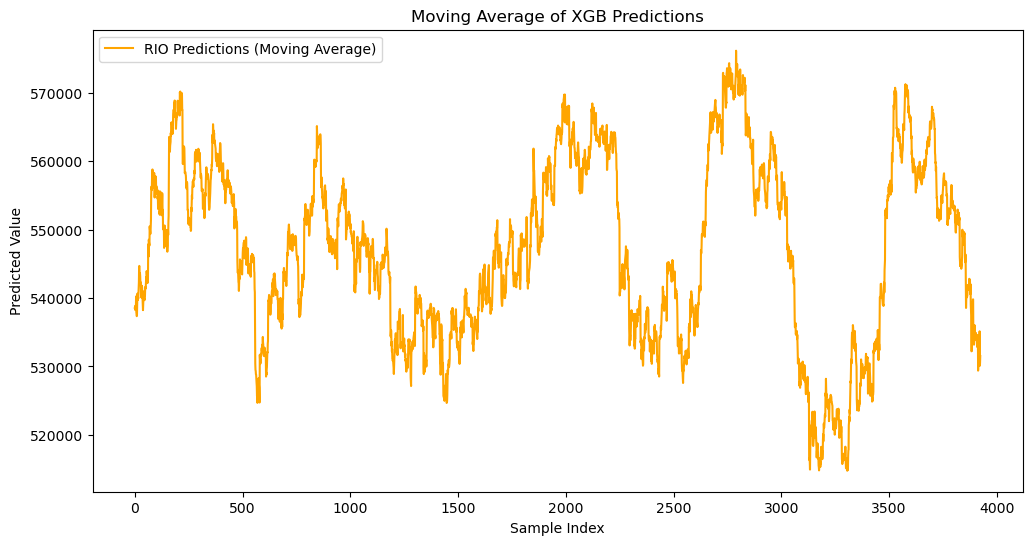

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def moving_average(data, window):
    return data.rolling(window=window).mean()

# Calculate the moving average values
window_size_pred = 400

y_test_pred_xgb_ma = moving_average(pd.Series(y_test_pred_xgb), window_size_pred)

# Remove NaN values from the moving averages
y_test_pred_xgb_ma = y_test_pred_xgb_ma.dropna()




# Generate the x-axis values
x_values = np.arange(len(y_test_pred_xgb_ma))

# Create a plot of the RIO predictions and uncertainty boundaries
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_test_pred_xgb_ma, label="RIO Predictions (Moving Average)", color='orange')


# Customize the plot
plt.xlabel("Sample Index")
plt.ylabel("Predicted Value")
plt.title("Moving Average of XGB Predictions")
plt.legend(loc='upper left')

# Show the plot
plt.show()
